# Projet - IA for HumanForyou

|Auteur 1|Auteur 2|Auteur 3|Auteur 4|N° groupe|
|---|---|---|---|---|
|Nathan Kiss|Paul Claus|Julien Lasserre|Nicolas Wira|5|

# Transformation des données

### Gérer les valeurs manquantes: 
Remplacer les "NA" dans les enquêtes par une constante qui indique une donnée non répondue, ou imputer les valeurs manquantes par des statistiques résumées comme la médiane ou la moyenne.

### Vérification de l'unicité de EmployeeID: 
Assurer que chaque EmployeeID est unique à travers les fichiers.

### Validation de la cohérence des données: 
Vérifier que toutes les entrées pour les variables catégorielles (comme BusinessTravel, EducationField, MaritalStatus) sont valides.

### Transformation des types de données :
Les colonnes indiquant String doivent être converties en types catégoriels appropriés.
Les valeurs Yes/No peuvent être transformées en variables binaires (0/1).
La variable Over18 est probablement redondante si tous les employés sont majeurs, donc à considérer pour la suppression.

### Ingénierie des caractéristiques :
Date/Heure: Convertir les horaires de travail en durée de travail et en heure moyenne d'arrivée et de départ.
Création de nouvelles caractéristiques: À partir des données existantes, comme le ratio entre MonthlyIncome et TotalWorkingYears pour évaluer le revenu par rapport à l'expérience.

### Normalisation/Standardisation :
Les variables continues peuvent être normalisées ou standardisées pour s'adapter à certains modèles d'IA.

### Agrégation des données :
Fusionner les différentes sources de données sur EmployeeID pour créer un jeu de données cohérent pour chaque employé.

-----------------------------------------------------------------------------------------------------------------------------

# Etape 1 : Préparation des données

Nous avons 5 fichiers à prendre en compte :
- general_data.csv
- employee_survey_data.csv
- manager_survey_data.csv
- in_time.csv
- out_time.csv

Commençons par transformer les données dans chaque fichier.

## Importations :

In [1]:
import numpy as np
import os
import matplotlib
import matplotlib as plt
from numpy.random import default_rng
#import tarfile
#from six.moves import urllib
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### General_data.csv

Voici l'ensemble des transformations que nous allons effectuer :

- Attrition : Remplacer "Yes" par 1 et "No" par 0
- BusinessTravel : OneHotEncoder en prenant les colonnes suivantes : "Non-Travel", "Travel-Rarely", "Travel-Frequently"
- Department : OneHotEncoder en prenant les colonnes suivantes : "Sales", "Research & Development", "Human Resources"
- EducationField : OneHotEncoder en prenant les colonnes suivantes : "Life Sciences", "Medical", "Technical Degree", "Marketing", "Human Resources", "Other"
- EmployeeCount : Toutes les lignes comportant la même valeur (1), nous la supprimerons.
- Gender : Remplacer "Male" par 0 et "Female" par 1
- JobRole : OneHotEncoder en prenant les colonnes suivantes : "HealthCare Representative", "Human Resources", "Laboratory Technician", "Manager", "Manufacturing Director", "Research Director", "Research Scientist", "Sales Executive", "Sales Representative"
- MarritalStatus : OneHotEncoder en prenant les colonnes suivantes : "Married", "Single", "Divorced"
- NumCompaniesWorked : Remplacer "NA" par la valeur médiane, car il est préférable d'avoir une valeur qui n'est pas 0 pour ne pas fausser le traitement.
- Over18 : Supprimer cet attribut, comme tous les employés ont plus de 18 ans.
- StandardHours : Supprimer cet attribut, comme tous les employés travaillent 8 heures par jour.
- TotalWorkingYears : Remplacer "NA" par la valeur médiane, car il n'y a que 9 valeurs "NA" et il est plus probable qu'ils aient travaillé plus d'un an.

--------------------------------------------------------------------------------------------------------------------------------

Préparons notre environnement, de la même manière que dans les workshops réalisés.

In [8]:
# stabilité du notebook d'une exécution à l'autre
random=default_rng(42) 

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# où sauver les figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "workflowDS"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID) # le dossier doit exister

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### On fusionne les fichiers .csv, excepté "in_time" et "out_time" que nous traiterons plus tard.

In [40]:
GENERAL_DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "datasets")
print(GENERAL_DATA_PATH)
if not os.path.isdir(GENERAL_DATA_PATH):
        os.makedirs(GENERAL_DATA_PATH)

def load_general_data(general_data_path=GENERAL_DATA_PATH):
    csv_path = os.path.join(general_data_path, "general_data.csv")
    csv_files = [".\\datasets\\general_data.csv", ".\\datasets\\employee_survey_data.csv", ".\\datasets\\manager_survey_data.csv"]
    merged_df = pd.read_csv(csv_files[0])

    for file in csv_files:
        df = pd.read_csv(file)
        print(f"Les colonnes de {file} sont : {df.columns.tolist()}")
        assert 'EmployeeID' in df.columns, f"EmployeeID non trouvé dans {file}"
    
    for file in csv_files[1:]:
        temp_df = pd.read_csv(file)
        merged_df = pd.merge(merged_df, temp_df, on="EmployeeID", how='inner')
    merged_df.to_csv("merged_files.csv", index=False)
    
    return merged_df #pd.read_csv(merged_df)

.\datasets


In [41]:
#general_data = load_general_data()
all_datas = load_general_data()

Les colonnes de .\datasets\general_data.csv sont : ['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender', 'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Les colonnes de .\datasets\employee_survey_data.csv sont : ['EmployeeID', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']
Les colonnes de .\datasets\manager_survey_data.csv sont : ['EmployeeID', 'JobInvolvement', 'PerformanceRating']


In [43]:
print(all_datas.head())

   Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeCount  EmployeeID  Gender  ...  \
0          2  Life Sciences              1           1  Female  ...   
1          1  Life Sciences              1           2  Female  ...   
2          4          Other              1           3    Male  ...   
3          5  Life Sciences              1           4    Male  ...   
4          1        Medical              1           5    Male  ...   

   TotalWorkingYears TrainingTimesLastYear YearsAtCompany  \
0                1.0     

In [44]:
print(all_datas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

### Ajout de la colonne "Temps_travail"
Nous allons calculer le temps de travail de chaque employé en fonction de in_time et out_time.

In [58]:
in_time = pd.read_csv(".\\datasets\\in_time.csv")
out_time = pd.read_csv(".\\datasets\\out_time.csv")
format_date = "%Y-%m-%d %H:%M:%S"

# Conversion de toutes les colonnes sauf la première (EmployeeID) en datetime
for column in in_time.columns[1:]:
    in_time[column] = pd.to_datetime(in_time[column], format=format_date, errors='coerce')
    out_time[column] = pd.to_datetime(out_time[column], format=format_date, errors='coerce')

# Initialisation de la liste avec les EmployeeID pour stocker les heures travaillées par jour
daily_hours_list = [in_time['Unnamed: 0'].rename('EmployeeID')]

# Calcul des heures travaillées pour chaque jour, puis préparation pour concaténation
for column in in_time.columns[1:]:
    daily_hours = (out_time[column] - in_time[column]).dt.total_seconds() / 3600
    daily_hours_list.append(daily_hours.rename(column))

# Concaténation de toutes les heures travaillées en une seule DataFrame
hours_worked = pd.concat(daily_hours_list, axis=1)

# Calcul de la moyenne des heures travaillées par jour pour chaque employé
hours_per_employee = hours_worked.set_index('EmployeeID').mean(axis=1).reset_index()
hours_per_employee.columns = ['EmployeeID', 'Heures_Travail_Moyennes']

# Supposition d'un DataFrame 'merged_data' existant
# merged_data = pd.DataFrame(...)  # Remplacez cela par votre DataFrame existant

# Fusion avec le DataFrame 'merged_data' existant sur 'EmployeeID'
all_datas = pd.merge(all_datas, hours_per_employee, on='EmployeeID', how='inner')


In [60]:
all_datas.drop(["Heures_Travail_Moyennes_x", "Heures_Travail_Moyennes_y"], axis=1, inplace=True)
all_datas.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Heures_Travail_Moyennes
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,3.0,4.0,2.0,3,3,7.373651
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,3.0,2.0,4.0,2,4,7.718969
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,2.0,2.0,1.0,3,3,7.013240
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,4.0,4.0,3.0,2,3,7.193678
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,4.0,1.0,3.0,3,3,8.006175


In [61]:
print(all_datas["BusinessTravel"].value_counts())

BusinessTravel
Travel_Rarely        3129
Travel_Frequently     831
Non-Travel            450
Name: count, dtype: int64


In [62]:
print(all_datas.describe())

               Age  DistanceFromHome    Education  EmployeeCount   EmployeeID  \
count  4410.000000       4410.000000  4410.000000         4410.0  4410.000000   
mean     36.923810          9.192517     2.912925            1.0  2205.500000   
std       9.133301          8.105026     1.023933            0.0  1273.201673   
min      18.000000          1.000000     1.000000            1.0     1.000000   
25%      30.000000          2.000000     2.000000            1.0  1103.250000   
50%      36.000000          7.000000     3.000000            1.0  2205.500000   
75%      43.000000         14.000000     4.000000            1.0  3307.750000   
max      60.000000         29.000000     5.000000            1.0  4410.000000   

          JobLevel  MonthlyIncome  NumCompaniesWorked  PercentSalaryHike  \
count  4410.000000    4410.000000         4391.000000        4410.000000   
mean      2.063946   65029.312925            2.694830          15.209524   
std       1.106689   47068.888559         

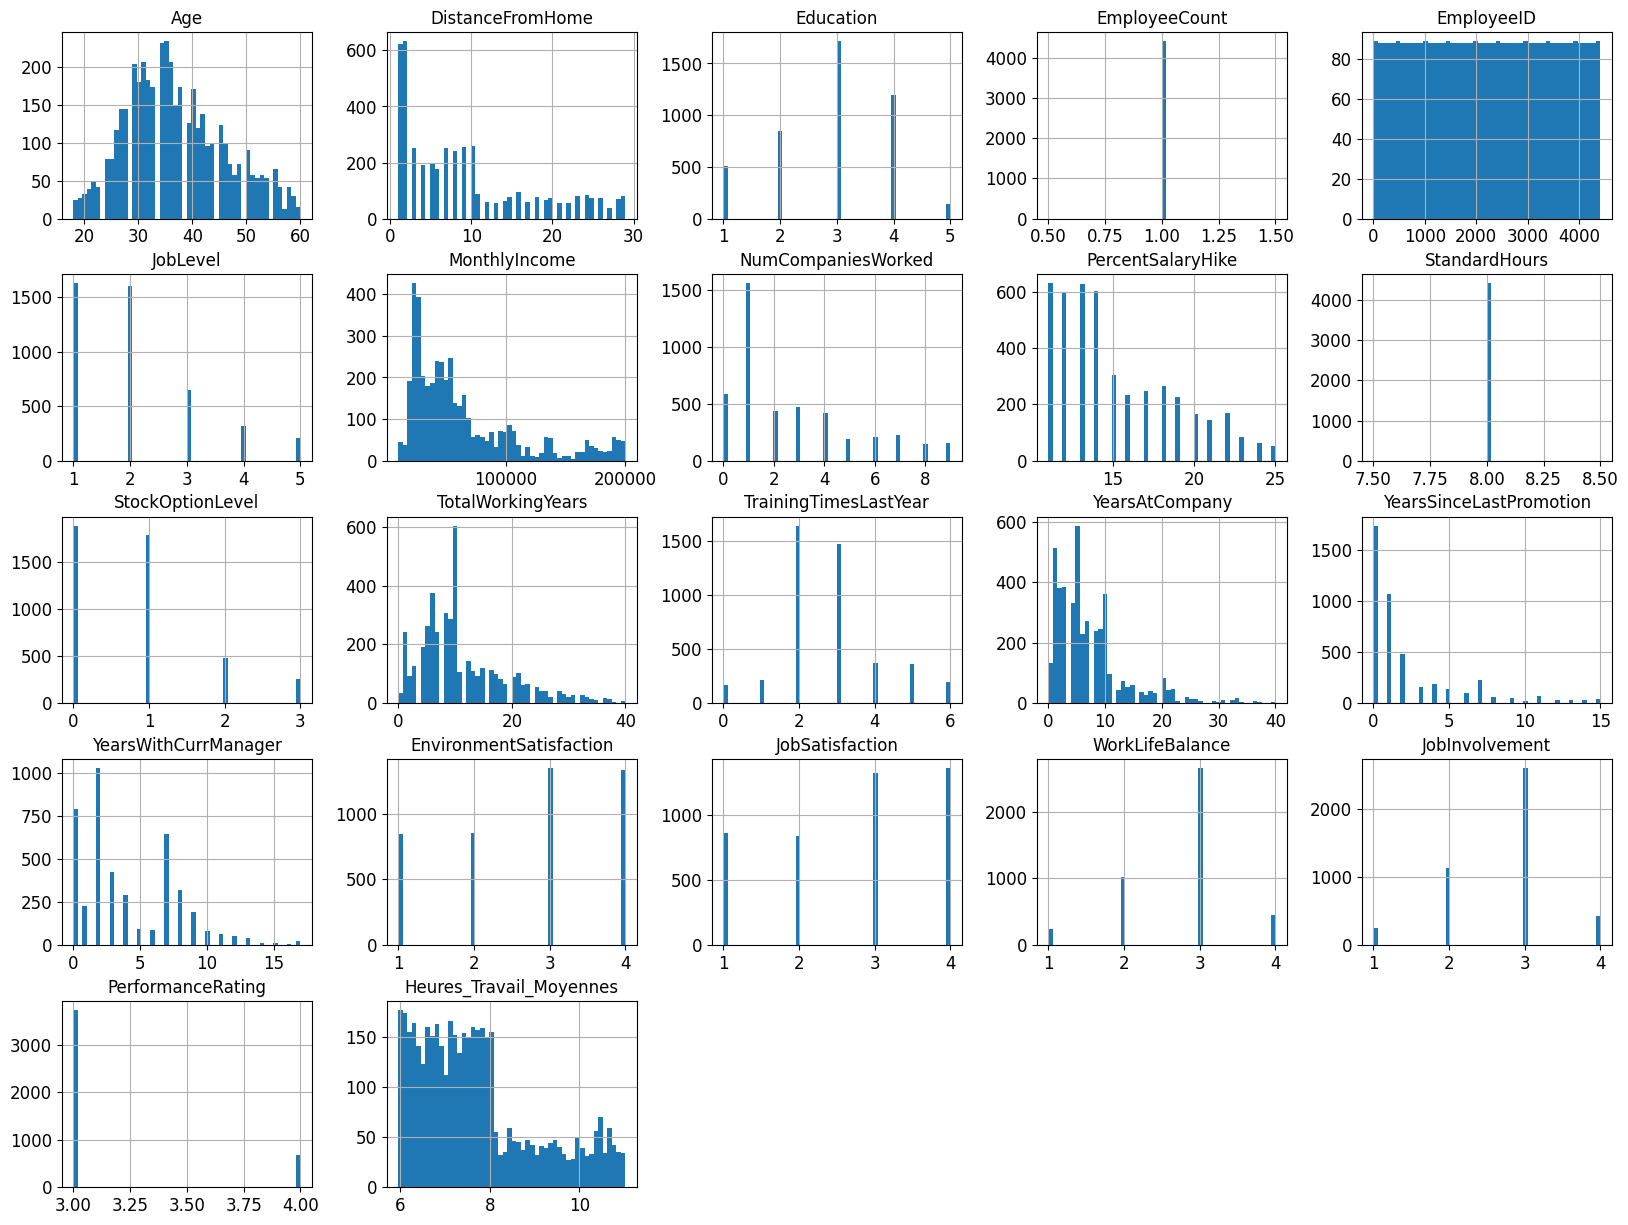

In [63]:
all_datas.hist(bins=50, figsize=(20, 15))
plt.show()

In [76]:
X = all_datas.copy()
X.drop("Over18", axis=1, inplace=True)
X.drop("EmployeeCount", axis=1, inplace=True)
X.drop("StandardHours", axis=1, inplace=True)
X["Attrition"] = X["Attrition"].map({"Yes": 1, "No": 0})
X["Gender"] = X["Gender"].map({"Male": 0, "Female": 1})

onehot_encoder = OneHotEncoder()

# Liste des colonnes catégorielles pour OneHotEncoding
colonnes_categorielles = ['BusinessTravel', 'Department', 'EducationField', 
                       'JobRole', 'MaritalStatus']

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X['NumCompaniesWorked'] = imputer.fit_transform(X['NumCompaniesWorked'].values.reshape(-1,1))
X['TotalWorkingYears'] = imputer.fit_transform(X['TotalWorkingYears'].values.reshape(-1,1))

column_transformer = ColumnTransformer(transformers=[('cat', onehot_encoder, colonnes_categorielles)], 
                                       remainder='passthrough')

X_encoded = column_transformer.fit_transform(X)
X_encoded = pd.DataFrame(X_encoded, columns=["BusinessTravel_Non-Travel",
"BusinessTravel_Travel_Frequently",
"BusinessTravel_Travel_Rarely",
"Department_Human Resources",
"Department_Research & Development",
"Department_Sales",
"EducationField_Human Resources",
"EducationField_Life Sciences",
"EducationField_Marketing",
"EducationField_Medical",
"EducationField_Other",
"EducationField_Technical Degree",
"JobRole_Healthcare Representative",
"JobRole_Human Resources",
"JobRole_Laboratory Technician",
"JobRole_Manager",
"JobRole_Manufacturing Director",
"JobRole_Research Director",
"JobRole_Research Scientist",
"JobRole_Sales Executive",
"JobRole_Sales Representative",
"MaritalStatus_Divorced",
"MaritalStatus_Married",
"MaritalStatus_Single",
"Age",
"Attrition",
"DistanceFromHome",
"Education",
"EmployeeID",
"Gender",
"JobLevel",
"MonthlyIncome",
"NumCompaniesWorked",
"PercentSalaryHike",
"StockOptionLevel",
"TotalWorkingYears",
"TrainingTimesLastYear",
"YearsAtCompany",
"YearsSinceLastPromotion",
"YearsWithCurrManager",
"EnvironmentSatisfaction",
"JobSatisfaction",
"WorkLifeBalance", 
"JobInvolvement", 
"PerformanceRating",
"Heures_Travail_Moyennes"
]) #column_transformer.get_feature_names_out())

X_encoded.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Heures_Travail_Moyennes
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,6.0,1.0,0.0,0.0,3.0,4.0,2.0,3.0,3.0,7.373651
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,3.0,5.0,1.0,4.0,3.0,2.0,4.0,2.0,4.0,7.718969
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,5.0,0.0,3.0,2.0,2.0,1.0,3.0,3.0,7.013240
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,5.0,8.0,7.0,5.0,4.0,4.0,3.0,2.0,3.0,7.193678
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,2.0,6.0,0.0,4.0,4.0,1.0,3.0,3.0,3.0,8.006175


In [77]:
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 46 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   BusinessTravel_Non-Travel          4410 non-null   float64
 1   BusinessTravel_Travel_Frequently   4410 non-null   float64
 2   BusinessTravel_Travel_Rarely       4410 non-null   float64
 3   Department_Human Resources         4410 non-null   float64
 4   Department_Research & Development  4410 non-null   float64
 5   Department_Sales                   4410 non-null   float64
 6   EducationField_Human Resources     4410 non-null   float64
 7   EducationField_Life Sciences       4410 non-null   float64
 8   EducationField_Marketing           4410 non-null   float64
 9   EducationField_Medical             4410 non-null   float64
 10  EducationField_Other               4410 non-null   float64
 11  EducationField_Technical Degree    4410 non-null   float

In [78]:
has_infinities = np.isinf(X_encoded).any()
if has_infinities.bool:
    print("IL Y A DES INFINIS")
    X_encoded = np.where(np.isinf(X_encoded), np.nan, X_encoded)

    # Ensuite, on peut choisir de remplacer tous les NaN par la médiane ou la moyenne de la colonne
    imputer = SimpleImputer(strategy='median')  # ou 'mean'
    X_encoded = imputer.fit_transform(X_encoded)


IL Y A DES INFINIS


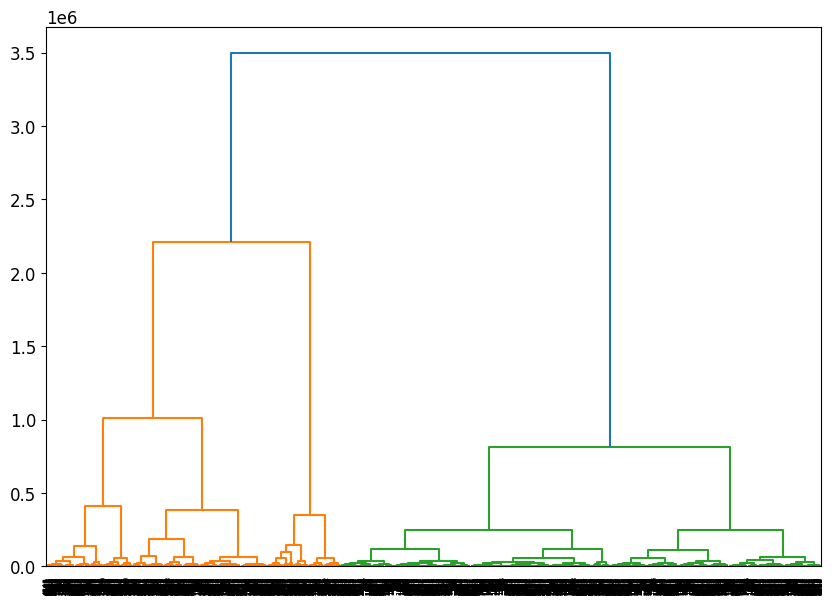

In [79]:
plt.figure(figsize=(10, 7))
dendrogram(linkage(X_encoded, method='ward'), orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

In [84]:
column_names = ["BusinessTravel_Non-Travel",
"BusinessTravel_Travel_Frequently",
"BusinessTravel_Travel_Rarely",
"Department_Human Resources",
"Department_Research & Development",
"Department_Sales",
"EducationField_Human Resources",
"EducationField_Life Sciences",
"EducationField_Marketing",
"EducationField_Medical",
"EducationField_Other",
"EducationField_Technical Degree",
"JobRole_Healthcare Representative",
"JobRole_Human Resources",
"JobRole_Laboratory Technician",
"JobRole_Manager",
"JobRole_Manufacturing Director",
"JobRole_Research Director",
"JobRole_Research Scientist",
"JobRole_Sales Executive",
"JobRole_Sales Representative",
"MaritalStatus_Divorced",
"MaritalStatus_Married",
"MaritalStatus_Single",
"Age",
"Attrition",
"DistanceFromHome",
"Education",
"EmployeeID",
"Gender",
"JobLevel",
"MonthlyIncome",
"NumCompaniesWorked",
"PercentSalaryHike",
"StockOptionLevel",
"TotalWorkingYears",
"TrainingTimesLastYear",
"YearsAtCompany",
"YearsSinceLastPromotion",
"YearsWithCurrManager",
"EnvironmentSatisfaction",
"JobSatisfaction",
"WorkLifeBalance", 
"JobInvolvement", 
"PerformanceRating",
"Heures_Travail_Moyennes"]
general_datas = pd.DataFrame(X_encoded, columns = column_names)

general_datas.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Heures_Travail_Moyennes
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,6.0,1.0,0.0,0.0,3.0,4.0,2.0,3.0,3.0,7.373651
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,3.0,5.0,1.0,4.0,3.0,2.0,4.0,2.0,4.0,7.718969
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,5.0,0.0,3.0,2.0,2.0,1.0,3.0,3.0,7.013240
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,5.0,8.0,7.0,5.0,4.0,4.0,3.0,2.0,3.0,7.193678
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,2.0,6.0,0.0,4.0,4.0,1.0,3.0,3.0,3.0,8.006175


# Création d'un jeu de test

Réservons maintenant un échantillon de test.

In [85]:
train_set, test_set = train_test_split(general_datas, test_size=0.2, random_state=42)

In [86]:
test_set.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Heures_Travail_Moyennes
1413,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,5.0,7.0,1.0,7.0,4.0,4.0,3.0,3.0,3.0,9.593415
3352,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,5.0,1.0,0.0,0.0,2.0,3.0,3.0,3.0,3.0,7.710115
3970,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,3.0,7.0,1.0,7.0,2.0,4.0,3.0,3.0,3.0,6.684643
3629,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,8.0,7.0,7.0,2.0,2.0,2.0,3.0,3.0,10.045850
144,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2.0,5.0,4.0,4.0,2.0,3.0,3.0,3.0,3.0,7.585974


In [93]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(general_datas, general_datas["Attrition"]):
    print(train_index, test_index) # 1 seul tour de boucle si n_splits = 1
    strat_train_set = general_datas.loc[train_index]
    strat_test_set = general_datas.loc[test_index]

[3465 3485 3052 ...  808 2946 1125] [3331 2050 1213 2355 2433 2626 3519  398 3763 3193  799 2627  493 1667
 1544 3397 3270 3381  340 2164 4347 1938 1151 2510  178 2344   13  395
 1604 1968 1380 2173 3135 2114 1777 3861  897 3338 4286 3122 2682  141
 2463 4058 3709 3328 1982  788 3227  842 2147 1448 3689 3031 3128 1959
 2388 2417 1194 4215 1519 2254  431 2365 1163 3781 1148 1511 3006  254
 3655   45 1833 3997 2257 3883 2805 3790   57 4392 4153 1073 3495 4274
  876 3024 3734 2002 2276 3987 1445 3558  450 4121  284 3114 3273  828
 4381 1409 1281 3289  999  954 1291 1953 1020 3048 4060  135 3952 2134
 1363  646  662 2809 1526  288 1880 3063 1758 3644 3592 4403  226 4227
 2271 3384 4303 1773  964 3387 2845  782 3121 3782 3000 1541 2716 2032
 1454   24 1334 1219 2502 1427 1150 1185  751 3454 1802 2779 2029 1891
 3009 3578 1718 2904 2852  225 3665 4282 3055 4330  170  481 1543  826
 1240 3343 4040  109 3060 1714 4382 4235 3502 1410 3476 3463 1319 2181
 1306  792 3758   43 1835 4113 3707  770 

<Axes: >

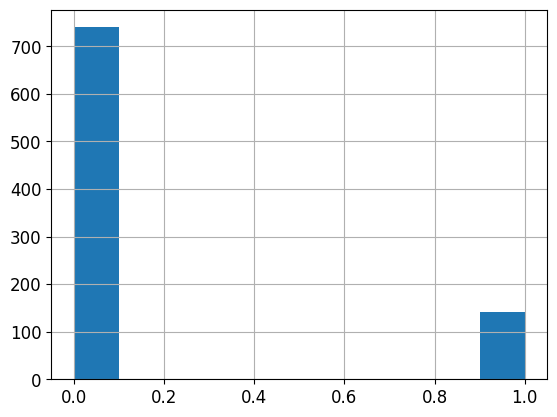

In [95]:
strat_test_set["Attrition"].hist()

<Axes: >

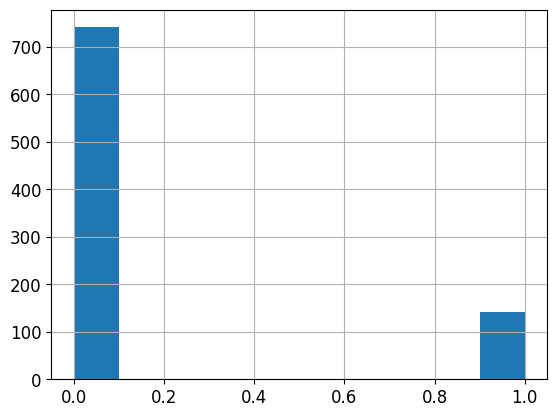

In [96]:
test_set["Attrition"].hist()

<Axes: >

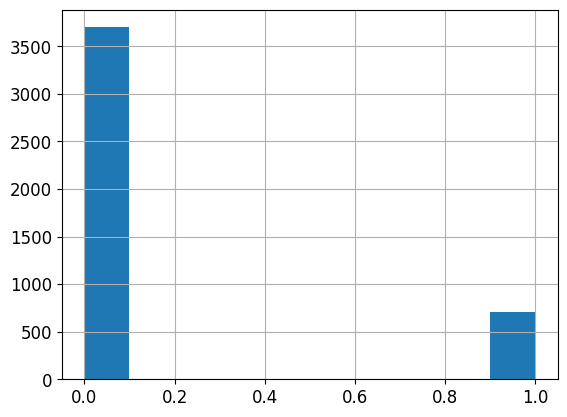

In [97]:
general_datas["Attrition"].hist()

In [98]:
HumanForAll = strat_train_set.copy()

On calcule la meilleure corrélation entre Attrition et un autre attribut :

In [100]:
print(HumanForAll.select_dtypes(include=[np.number]).corr()["Attrition"].sort_values(ascending=False))

Attrition                            1.000000
Heures_Travail_Moyennes              0.205508
MaritalStatus_Single                 0.184688
BusinessTravel_Travel_Frequently     0.113523
EducationField_Human Resources       0.090823
Department_Human Resources           0.073982
NumCompaniesWorked                   0.035943
JobRole_Sales Executive              0.027309
JobRole_Research Director            0.024505
JobRole_Research Scientist           0.024009
PercentSalaryHike                    0.021249
EducationField_Life Sciences         0.013432
PerformanceRating                    0.011618
EmployeeID                           0.006769
Education                            0.000362
JobInvolvement                      -0.003038
JobRole_Sales Representative        -0.003658
Department_Research & Development   -0.007040
EducationField_Other                -0.008038
EducationField_Marketing            -0.008450
JobRole_Laboratory Technician       -0.008632
EducationField_Medical            

Saving figure scatter_matrix_plot


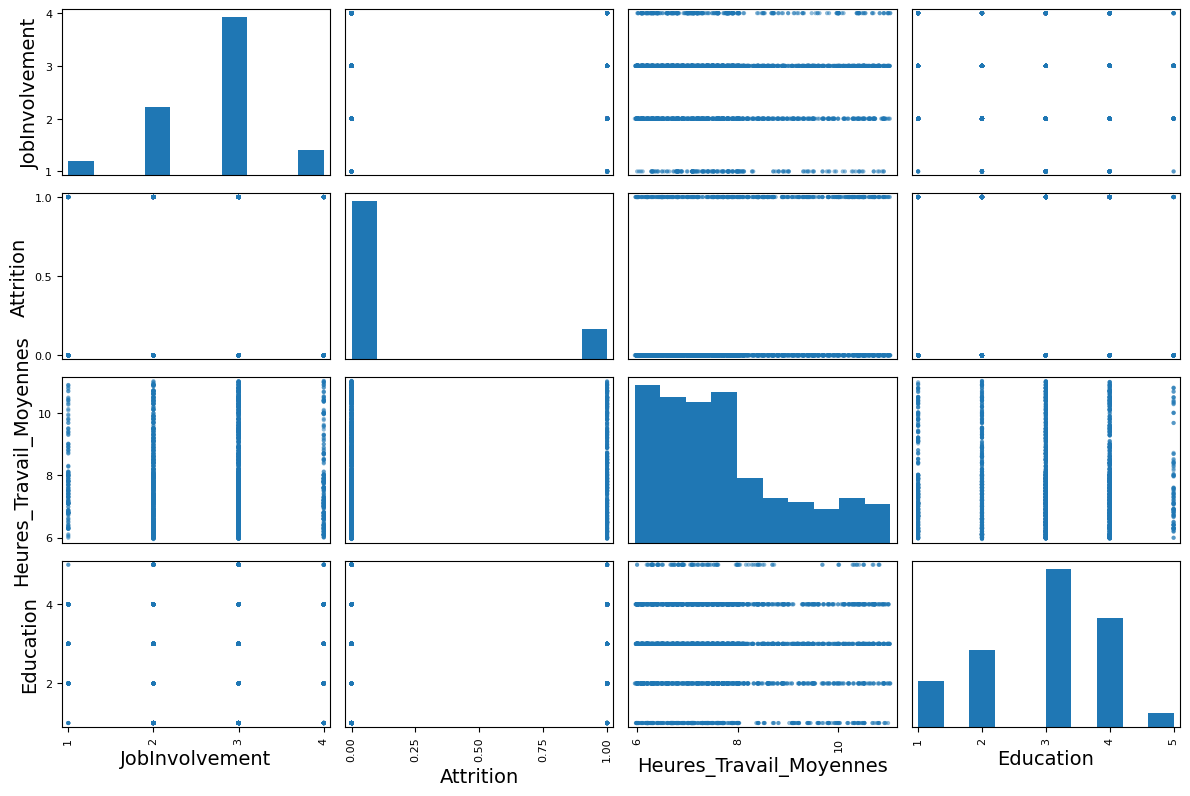

In [101]:
attributes = ["JobInvolvement","Attrition", "Heures_Travail_Moyennes", "Education"]
scatter_matrix(HumanForAll[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [103]:
HumanForAll = strat_train_set.drop("Attrition", axis=1)
HumanForAll_labels = strat_train_set["Attrition"].copy()

In [104]:
HumanForAll.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3528 entries, 3465 to 1125
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   BusinessTravel_Non-Travel          3528 non-null   float64
 1   BusinessTravel_Travel_Frequently   3528 non-null   float64
 2   BusinessTravel_Travel_Rarely       3528 non-null   float64
 3   Department_Human Resources         3528 non-null   float64
 4   Department_Research & Development  3528 non-null   float64
 5   Department_Sales                   3528 non-null   float64
 6   EducationField_Human Resources     3528 non-null   float64
 7   EducationField_Life Sciences       3528 non-null   float64
 8   EducationField_Marketing           3528 non-null   float64
 9   EducationField_Medical             3528 non-null   float64
 10  EducationField_Other               3528 non-null   float64
 11  EducationField_Technical Degree    3528 non-null   float64

In [ ]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)